In [48]:
import warnings
warnings.filterwarnings("ignore")

In [49]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from matplotlib import animation
import numpy as np
import xarray as xr
from IPython.display import HTML

from tool.dataset import NetCDFDataset
from tool.loss import RMSELoss
from tool.utils import Util, ImgUtil

from model.stconvs2s import STConvS2S_R

## Loading Data With Different Resolutions

In [3]:
file_hr = './data/eta_eulerian_resolution_20.0km.nc'
file_lr = './data/eta_eulerian_resolution_100.0km.nc'

In [4]:
# loading outputs from shallow water model and transposing dimensions
ds_hr = xr.open_mfdataset(file_hr).transpose('time', 'y', 'x')
ds_lr = xr.open_mfdataset(file_lr).transpose('time', 'y', 'x')

In [5]:
da_hr = ds_hr.rename({'__xarray_dataarray_variable__':'eta'}).eta
da_lr = ds_lr.rename({'__xarray_dataarray_variable__':'eta'}).eta

In [6]:
# interpolation - from 100x100 to 20x20
da_hr_interp = da_hr.interp(y=da_lr.y, x=da_lr.x, method='linear')
da_hr_interp_v = da_hr_interp.values

In [7]:
# filtering only time steps present in coarse resolution
da_hr_interp_subset = da_hr_interp.isel(time=slice(0, da_hr_interp.time.size - 1, 5))

In [8]:
da_lr_v = da_lr.values
da_hr_interp_subset_v = da_hr_interp_subset.values

In [9]:
da_hr_interp_subset

<xarray.DataArray 'eta' (time: 7331, y: 20, x: 20)>
dask.array<shape=(7331, 20, 20), dtype=float64, chunksize=(7331, 20, 20)>
Coordinates:
  * time     (time) float64 0.0 353.6 707.1 ... 2.591e+06 2.591e+06 2.592e+06
  * y        (y) float64 -1e+06 -9e+05 -8e+05 -7e+05 ... 6e+05 7e+05 8e+05 9e+05
  * x        (x) float64 0.0 1e+05 2e+05 3e+05 ... 1.7e+06 1.8e+06 1.9e+06

In [10]:
da_lr

<xarray.DataArray 'eta' (time: 7331, y: 20, x: 20)>
dask.array<shape=(7331, 20, 20), dtype=float64, chunksize=(7331, 20, 20)>
Coordinates:
  * time     (time) float64 0.0 353.6 707.1 ... 2.591e+06 2.591e+06 2.592e+06
  * y        (y) float64 -1e+06 -9e+05 -8e+05 -7e+05 ... 6e+05 7e+05 8e+05 9e+05
  * x        (x) float64 0.0 1e+05 2e+05 3e+05 ... 1.7e+06 1.8e+06 1.9e+06

### Loading Predictions and Trained Models

In [50]:
def load_predictions(data, hora):
    folder = '/home/guinelli/mestrado/stconvs2s/output/full-dataset/predictions/stconvs2s-r/'
    
    inputs = torch.load(folder + 'shalow_water_x_step_5_y_step_20_4_' + data + '-' + hora + '_input.pt').cpu().numpy()
    targets = torch.load(folder + 'shalow_water_x_step_5_y_step_20_4_' + data + '-' + hora + '_target.pt').cpu().numpy()
    predictions = torch.load(folder + 'shalow_water_x_step_5_y_step_20_4_' + data + '-' + hora + '_predictions.pt').cpu().numpy()
    
    return inputs, targets, predictions

In [51]:
def load_checkpoint(filename, model_name, dataset_type=None, model=None):
    if not(os.path.isabs(filename)):
        filename = os.path.join('/home/guinelli/mestrado/stconvs2s/output', dataset_type, 'checkpoints', model_name.lower(), filename)  
    epoch, loss = 0.0, 0.0
    if os.path.isfile(filename):
        checkpoint = torch.load(filename)
        name = os.path.basename(filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        print(f'=> Loaded checkpoint {name} (best epoch: {epoch}, validation rmse: {loss:.4f})')
    else:
        print(f'=> No checkpoint found at {filename}')

    return model

In [70]:
models = []
models.append({'name': 'NN Reg 0    lr 1e-4', 't_data': '20210326', 't_time': '014628'})
models.append({'name': 'NN Reg 1e0  lr 1e-4', 't_data': '20210326', 't_time': '030533'})
models.append({'name': 'NN Reg 1e-1 lr 1e-4', 't_data': '20210326', 't_time': '042447'})
models.append({'name': 'NN Reg 1e-2 lr 1e-4', 't_data': '20210326', 't_time': '054310'})
models.append({'name': 'NN Reg 1e-3 lr 1e-4', 't_data': '20210326', 't_time': '070153'})
models.append({'name': 'NN Reg 1e-4 lr 1e-4', 't_data': '20210326', 't_time': '082001'})
models.append({'name': 'NN Reg 1e-5 lr 1e-4', 't_data': '20210326', 't_time': '093933'})
models.append({'name': 'NN Reg 1e-6 lr 1e-4', 't_data': '20210326', 't_time': '105829'})


models.append({'name': 'NN Reg 0    lr 1e-3', 't_data': '20210326', 't_time': '153636'})
models.append({'name': 'NN Reg 1e0  lr 1e-3', 't_data': '20210326', 't_time': '165521'})
models.append({'name': 'NN Reg 1e-1 lr 1e-3', 't_data': '20210326', 't_time': '181350'})
models.append({'name': 'NN Reg 1e-2 lr 1e-3', 't_data': '20210326', 't_time': '193248'})
models.append({'name': 'NN Reg 1e-3 lr 1e-3', 't_data': '20210326', 't_time': '205108'})
models.append({'name': 'NN Reg 1e-4 lr 1e-3', 't_data': '20210326', 't_time': '220945'})
models.append({'name': 'NN Reg 1e-5 lr 1e-3', 't_data': '20210326', 't_time': '232843'})

In [71]:
# same parameters from training
x_shape = [1, 1, 5, 20, 20]
num_layers = 3
hidden_dim = 32
kernel_size = 3
device = torch.device('cuda')
dropout_rate = 0
step = 20

In [72]:
i=0
for m in models:
    m['inputs'], m['targets'], m['predictions'] = load_predictions(m['t_data'], m['t_time'])
    filename = 'shalow_water_x_step_5_y_step_20_4_' + m['t_data'] + '-' + m['t_time'] + '.pth.tar'
    model = STConvS2S_R(x_shape, num_layers, hidden_dim, kernel_size, device, dropout_rate, step)
    model.to(device)
    m['model'] = load_checkpoint(filename, 'stconvs2s-r', 'full-dataset', model)
    m['i']=i
    i+=1

=> Loaded checkpoint shalow_water_x_step_5_y_step_20_4_20210326-014628.pth.tar (best epoch: 30, validation rmse: 0.0012)
=> Loaded checkpoint shalow_water_x_step_5_y_step_20_4_20210326-030533.pth.tar (best epoch: 9, validation rmse: 0.0309)
=> Loaded checkpoint shalow_water_x_step_5_y_step_20_4_20210326-042447.pth.tar (best epoch: 26, validation rmse: 0.0136)
=> Loaded checkpoint shalow_water_x_step_5_y_step_20_4_20210326-054310.pth.tar (best epoch: 28, validation rmse: 0.0048)
=> Loaded checkpoint shalow_water_x_step_5_y_step_20_4_20210326-070153.pth.tar (best epoch: 11, validation rmse: 0.0032)
=> Loaded checkpoint shalow_water_x_step_5_y_step_20_4_20210326-082001.pth.tar (best epoch: 28, validation rmse: 0.0017)
=> Loaded checkpoint shalow_water_x_step_5_y_step_20_4_20210326-093933.pth.tar (best epoch: 25, validation rmse: 0.0014)
=> Loaded checkpoint shalow_water_x_step_5_y_step_20_4_20210326-105829.pth.tar (best epoch: 27, validation rmse: 0.0013)
=> Loaded checkpoint shalow_water

## Getting Data for Simulation

In [73]:
ds = xr.open_mfdataset('/home/guinelli/mestrado/stconvs2s/data/dataset-shallow-water-eta-20.0km-yseq20-ystep10.nc')

In [74]:
# getting last 20% of the dataset for test
start_i = int(np.ceil(ds.x.shape[0] * 0.85))

In [75]:
# generating input and expected output (target)
ds = da_hr_interp_v[start_i::10,:,:][:245]
x, y = ds[0:5][None, None], ds[5:][None, None]
x = torch.tensor(x, dtype=torch.float)

In [76]:
# aprox. 12min * 240 (aprox. 2 days)
x.shape, y.shape

(torch.Size([1, 1, 5, 20, 20]), (1, 1, 240, 20, 20))

### Making Predictions

In [77]:
def make_predictions(model, initial_input, steps, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        i_input = initial_input
        i_input = i_input.to(device)
        for i in range(steps):
            output = model(i_input)
            predictions.append(output)
            i_input = output[:,:,-5:]
    
    return predictions

In [78]:
for m in models:
    pred = make_predictions(model=m['model'], initial_input=x, steps=12, device=device)
    pred = torch.cat(pred, dim=2)
    m['pred'] = np_pred = pred.cpu().numpy()

## Analysing Predictions

In [79]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = torch.nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y) + 1e-6 )

In [80]:
def get_loss(target, output):
    rmse_loss, mae_loss, x = [], [], []
    #criterium = torch.nn.MSELoss()
    criterium = RMSELoss()

    for i in range(target.shape[2]):
        yhat, y = output[:,:,i,:,:], target[:,:,i,:,:]
        yhat, y = torch.from_numpy(yhat), torch.from_numpy(y)
        rmse_loss.append(criterium(yhat, y))
        mae_loss.append(F.l1_loss(yhat, y))
        
    return rmse_loss, mae_loss

## Conservation of Mass

In [81]:
for m in models:
    m['sum'] = np.squeeze(m['pred']).sum(1).sum(1)

In [82]:
sum_lr = da_lr_v[::2].sum(1).sum(1)
sum_hr = da_hr_interp_subset_v[::2].sum(1).sum(1)
sum_hr2 = da_hr.values[::10].sum(1).sum(1) / 25

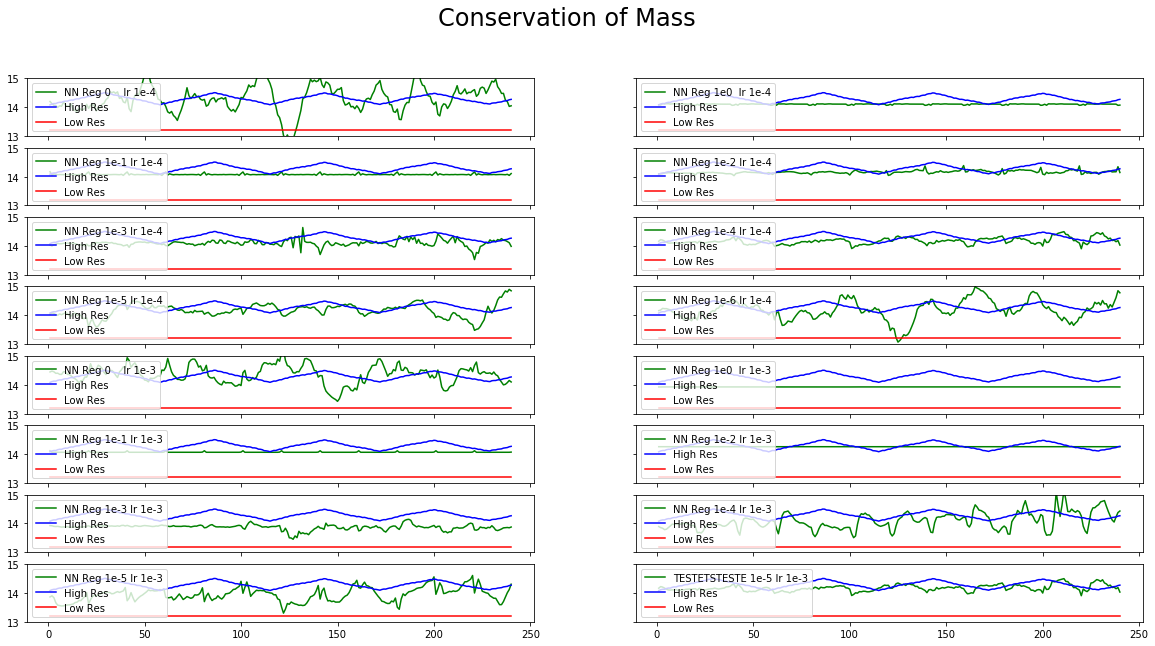

In [83]:
length = 240
x = np.arange(1,length+1)

fig, axs = plt.subplots((len(models)+1)//2, 2, figsize=(20,10), sharex=True, sharey=True)
fig.suptitle("Conservation of Mass", size=24)
for i, m in enumerate(models):
    l, c = i//2, i%2
    axs[l, c].plot(x, m['sum'][:length], "-g", label=m["name"])
    axs[l, c].plot(x, sum_hr[:length], "-b", label="High Res")
    axs[l, c].plot(x, sum_lr[:length], "-r", label="Low Res")
    axs[l, c].legend(loc="upper left")
plt.ylim(13, 15)
plt.show()

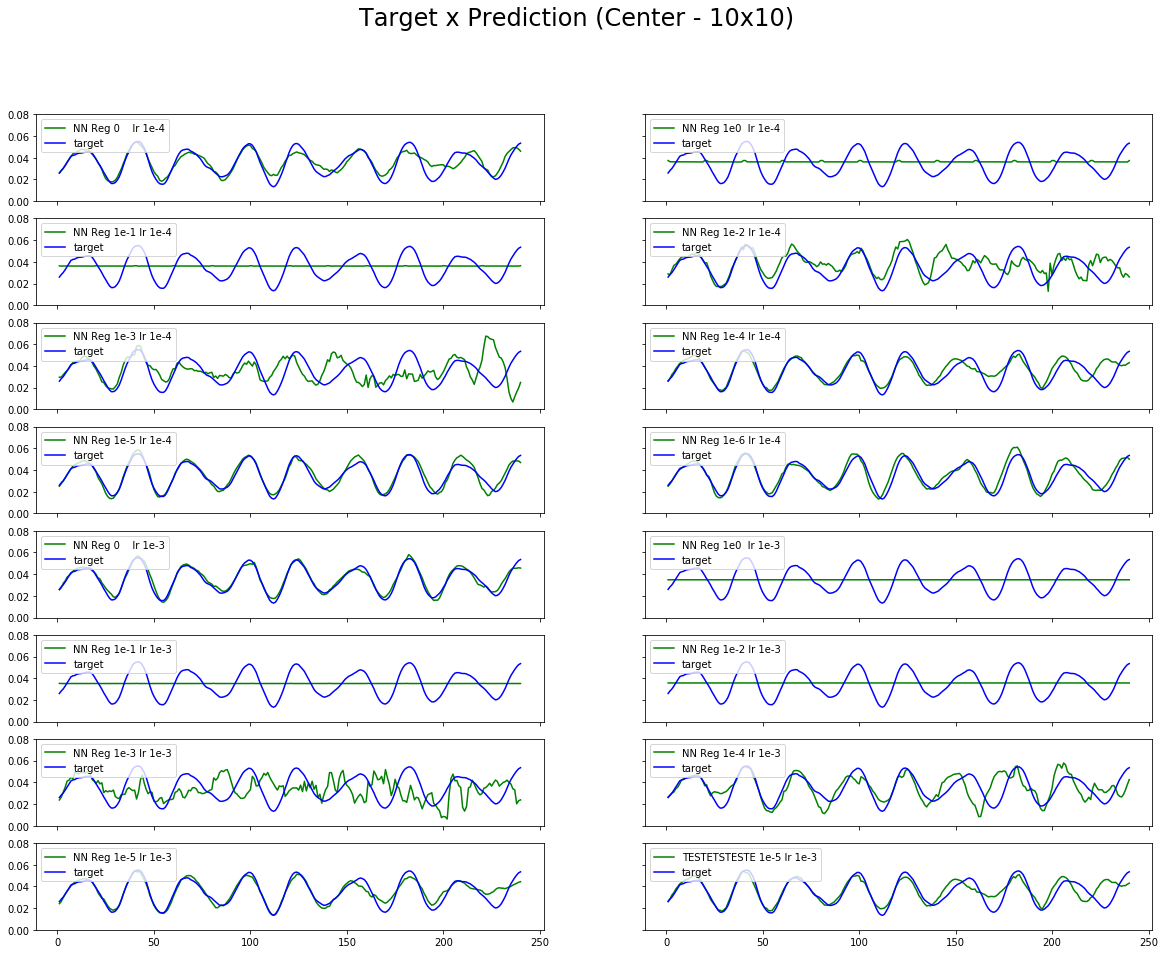

In [84]:
length = 240
x = np.arange(1,length+1)

fig, axs = plt.subplots((len(models)+1)//2, 2, figsize=(20,15), sharex=True, sharey=True)
fig.suptitle("Target x Prediction (Center - 10x10)", size=24)
for i, m in enumerate(models):
    l, c = i//2, i%2
    axs[l, c].plot(x, m['pred'][0,0,:length,10,10], "-g", label=m["name"])
    axs[l, c].plot(x, y[0,0,:length,10,10], "-b", label="target")
    axs[l, c].legend(loc="upper left")
plt.ylim(0, 0.08)
plt.show()

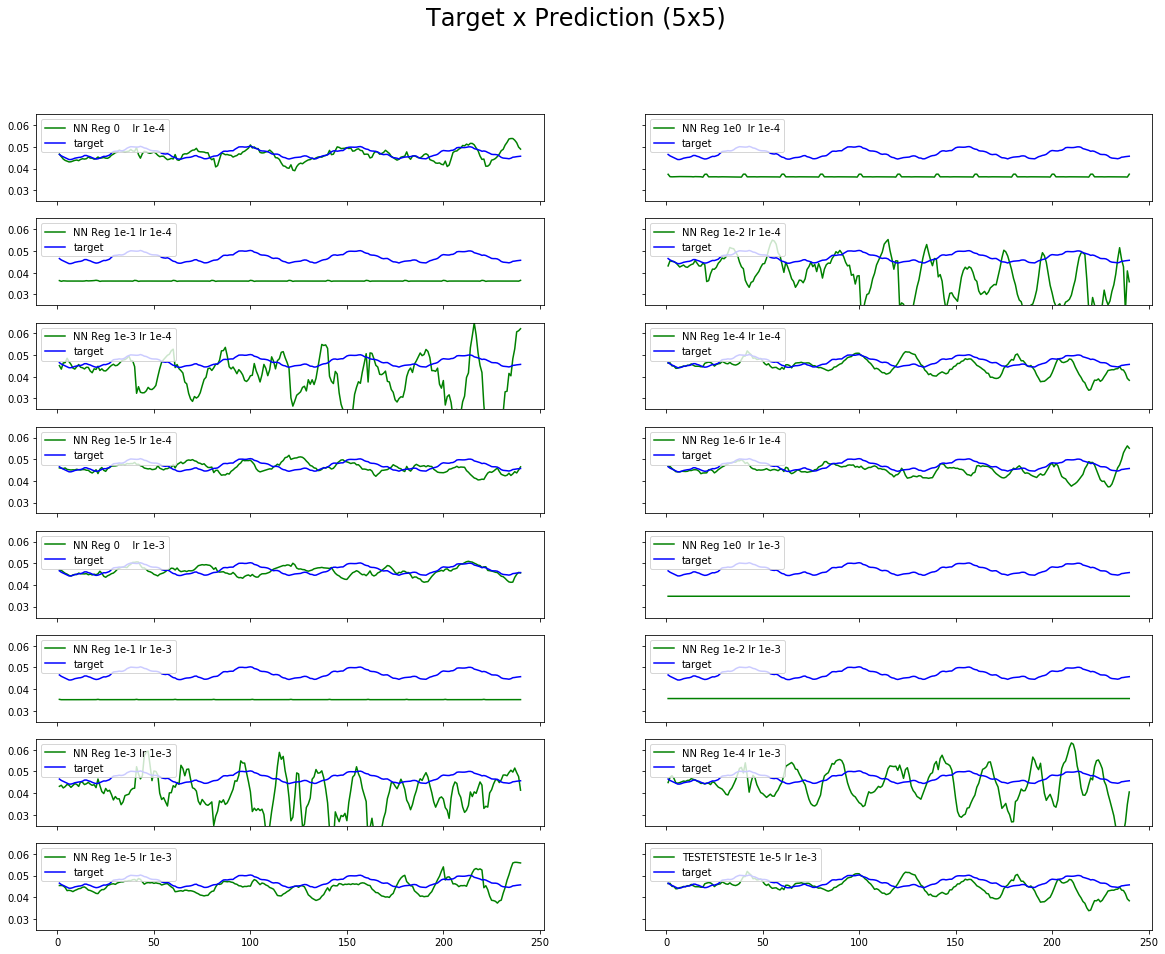

In [86]:
length = 240
x = np.arange(1,length+1)

fig, axs = plt.subplots((len(models)+1)//2, 2, figsize=(20,15), sharex=True, sharey=True)
fig.suptitle("Target x Prediction (5x5)", size=24)
for i, m in enumerate(models):
    l, c = i//2, i%2
    axs[l, c].plot(x, m['pred'][0,0,:length,5,5], "-g", label=m["name"])
    axs[l, c].plot(x, y[0,0,:length,5,5], "-b", label="target")
    axs[l, c].legend(loc="upper left")
#plt.plot(np.arange(1,length+1), np_pred[0,0,:length,10,10], "-g", label="output")
#plt.legend(loc="upper left")
plt.ylim(0.025, 0.065)
plt.show()

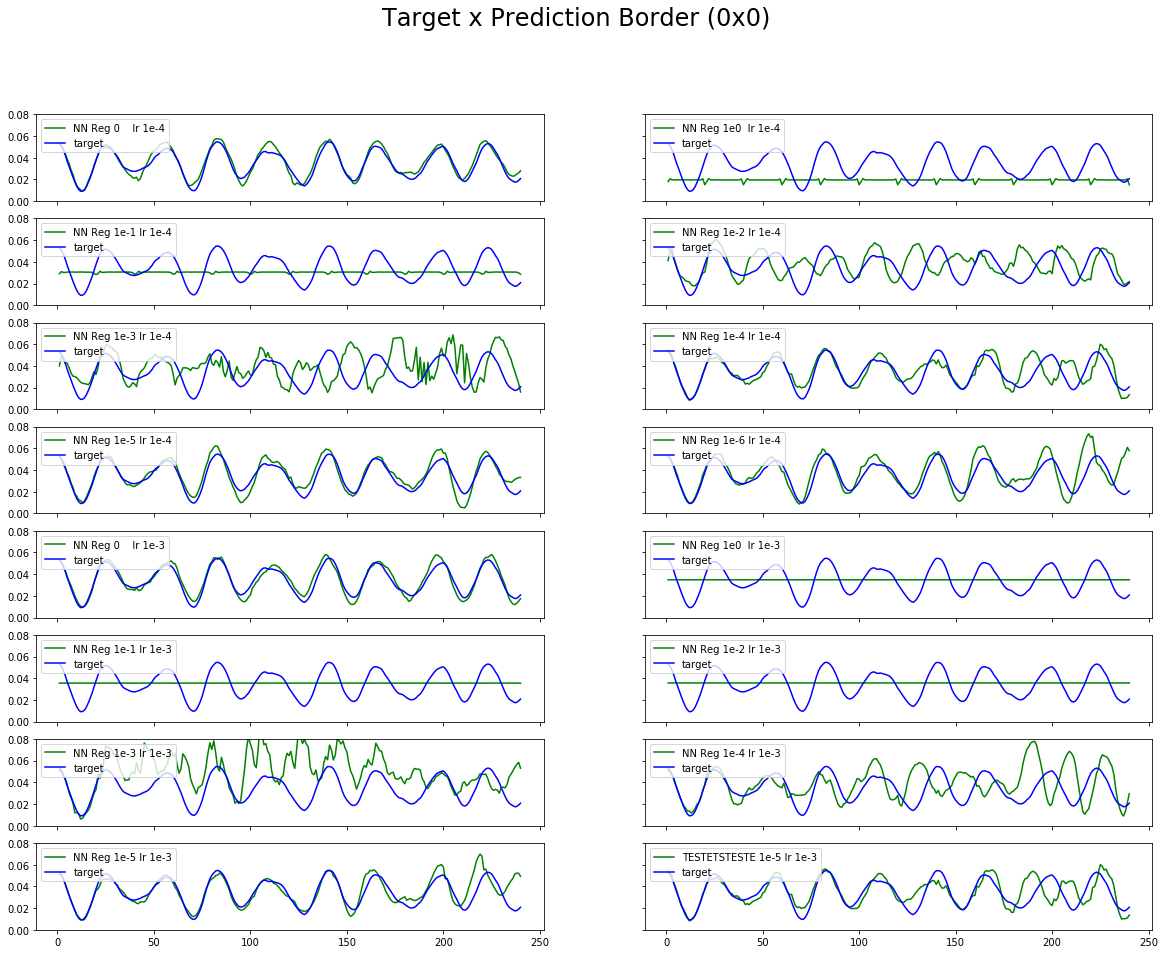

In [87]:
length = 240
x = np.arange(1,length+1)

fig, axs = plt.subplots((len(models)+1)//2, 2, figsize=(20,15), sharex=True, sharey=True)
fig.suptitle("Target x Prediction Border (0x0)", size=24)
for i, m in enumerate(models):
    l, c = i//2, i%2
    axs[l, c].plot(x, m['pred'][0,0,:length,0,0], "-g", label=m["name"])
    axs[l, c].plot(x, y[0,0,:length,0,0], "-b", label="target")
    axs[l, c].legend(loc="upper left")
#plt.plot(np.arange(1,length+1), np_pred[0,0,:length,10,10], "-g", label="output")
#plt.legend(loc="upper left")
plt.ylim(0, 0.08)
plt.show()

## Errors

In [88]:
for m in models:
    m['rmse'], m['mae'] = get_loss(np.float64(m['pred']), y)

In [89]:
rmse_lr, mae_lr = get_loss(da_hr_interp_subset_v[::2][None, None], da_lr_v[::2][None, None])

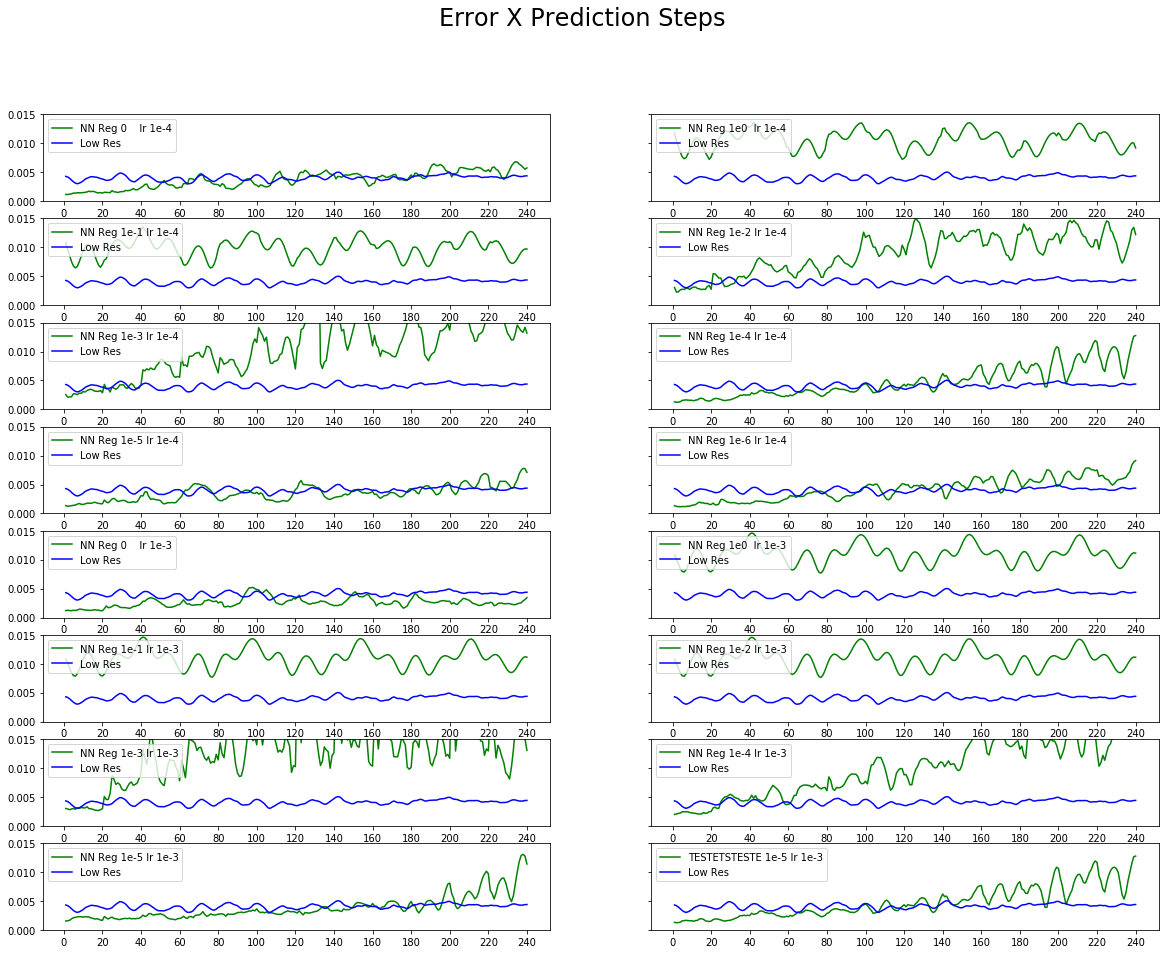

In [90]:
length = 240
x = np.arange(1,length+1)

fig, axs = plt.subplots((len(models)+1)//2, 2, figsize=(20,15), sharey=True)
fig.suptitle("Error X Prediction Steps", size=24)
for i, m in enumerate(models):
    l, c = i//2, i%2
    axs[l, c].plot(x, m['rmse'][:length], "-g", label=m["name"])
    axs[l, c].plot(x, rmse_lr[:length], "-b", label="Low Res")
    axs[l, c].legend(loc="upper left")
    axs[l, c].set_xticks(np.arange(0, length+1, 20))
plt.ylim(0, 0.015)
plt.show()